<h2>Install Packages</h2>

In [ ]:
#Reference for this code came from https://docs.ray.io/en/latest/rllib/rllib-algorithms.html#dqn
!pip install ray
!pip install gymnasium
!pip install "gymnasium[atari]"
!pip install "gymnasium[accept-rom-license]"
!pip install -U tensorboardx

import ray
import gymnasium 
import torch
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
                 
from ray.rllib.algorithms.dqn.dqn import DQNConfig
from ray.rllib.algorithms.ppo import PPOConfig
from ray.tune.logger import pretty_print
from ray import air, tune


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


<h3>Select device</h3>

In [ ]:
device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device('cuda')

print("Selected device:",device)

Selected device: cuda


<h3>Train</h3>

In [ ]:
#Reference for this code came from https://docs.ray.io/en/latest/rllib/rllib-algorithms.html#dqn

environ = "Riverraid-ramDeterministic-v4"
episodes = 200

parameters = [
      {"experiment_id":1, "capacity":5000, "prioritized_replay_alpha": 0.6,"prioritized_replay":False, "episodes":episodes, "display":["prioritized_replay"]}
     ,{"experiment_id":2, "capacity":5000, "prioritized_replay_alpha": 0.6,"prioritized_replay":True, "episodes":episodes, "display":["prioritized_replay"]}
]

final_results = []
for param in parameters:
  config = DQNConfig()
  config = config.environment(environ)
  config.replay_buffer_config["capacity"] = param["capacity"]
  config.replay_buffer_config["prioritized_replay_alpha"] = param["prioritized_replay_alpha"]
  config.double_q = True
  if torch.cuda.is_available(): config = config.resources(num_gpus = 1)
  config.replay_buffer_config["prioritized_replay"] = param["prioritized_replay"]
  algo = config.build()


  episode_results = []
  start_time = datetime.now()
  for episode in range(param["episodes"]):
      results = algo.train()
      episode_results.append({"experiment_id": param["experiment_id"], "parameters": param, "episode": episode,"episode_mean_reward": results["episode_reward_mean"]})
      if episode%10==0:
        end_time = datetime.now()
        time_diff = end_time-start_time
        print("Epoch",episode,"Episode Mean Reward",results["episode_reward_mean"], "Duration(s)",time_diff.total_seconds())
        start_time = datetime.now()
  final_results += episode_results





2023-04-23 10:40:17,470	WARNING util.py:67 -- Install gputil for GPU system monitoring.


Epoch 0 Episode Mean Reward 1500.0 Duration(s) 8.1752
Epoch 10 Episode Mean Reward 909.5833333333334 Duration(s) 244.956353
Epoch 20 Episode Mean Reward 912.7083333333334 Duration(s) 241.427277
Epoch 30 Episode Mean Reward 949.1428571428571 Duration(s) 241.674807
Epoch 40 Episode Mean Reward 980.6593406593406 Duration(s) 240.599006
Epoch 50 Episode Mean Reward 983.9 Duration(s) 239.134417
Epoch 60 Episode Mean Reward 1057.7 Duration(s) 243.31618
Epoch 70 Episode Mean Reward 1178.1 Duration(s) 240.073083
Epoch 80 Episode Mean Reward 1227.7 Duration(s) 239.206643
Epoch 90 Episode Mean Reward 1220.7 Duration(s) 238.586118


2023-04-23 11:20:14,320	WARNING util.py:67 -- Install gputil for GPU system monitoring.


Epoch 0 Episode Mean Reward 1420.0 Duration(s) 4.832803
Epoch 10 Episode Mean Reward 959.5238095238095 Duration(s) 233.792658
Epoch 20 Episode Mean Reward 814.8076923076923 Duration(s) 237.20362
Epoch 30 Episode Mean Reward 844.6753246753246 Duration(s) 238.565059
Epoch 40 Episode Mean Reward 890.3157894736842 Duration(s) 238.598104
Epoch 50 Episode Mean Reward 902.0 Duration(s) 239.625361
Epoch 60 Episode Mean Reward 1006.0 Duration(s) 238.841663
Epoch 70 Episode Mean Reward 1107.4 Duration(s) 237.986472
Epoch 80 Episode Mean Reward 1182.7 Duration(s) 239.104955
Epoch 90 Episode Mean Reward 1255.8 Duration(s) 237.815239


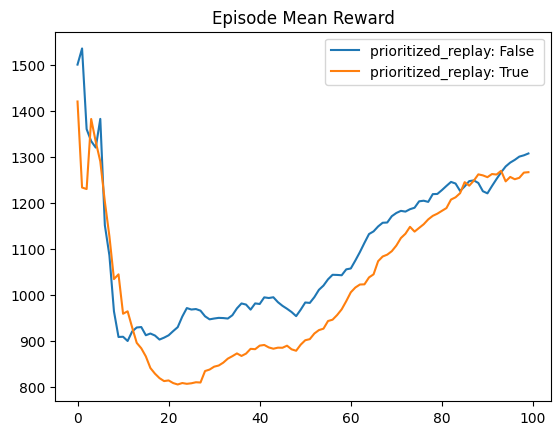

In [ ]:
for params in parameters:
    # Get the experiment id
    id = params["experiment_id"]
    display_params = params["display"]
    # Get all the results for this experiment
    exp_res = [res for res in final_results if res["experiment_id"] == id]
    
    # Build the label
    display_label = ""
    for item in display_params:
        display_label += item + ": " + str(params[item]) + " "


    # For the experiment, get the metrics to display
    rewards = np.array([[res["episode"], res["episode_mean_reward"], 0] for res in exp_res])

    for i in range(len(rewards)):
        rewards[i][2] = sum(rewards[0:i + 1, [1]]) / (i + 1)  # calculate the average cumulative reward

    plt.figure(1)
    plt.plot(rewards[:, [0]], rewards[:, [1]], label=display_label)
    plt.title("Episode Mean Reward")

plt.figure(1)
plt.legend()

plt.show()